In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

In [4]:
!pip install jcopdl==1.1.1
!wget https://github.com/WiraDKP/deep_learning/raw/master/16%20-%20Recurrent%20Neural%20Network/data.zip
!unzip data.zip

  Preparing metadata (setup.py) ... done
  Created wheel for jcopdl: filename=jcopdl-1.1.1-py2.py3-none-any.whl size=12589 sha256=b1d36d54eab9bb7f7f47334f3d2409f827f05ed4017c247e07181fb1070e373d
  Stored in directory: /root/.cache/pip/wheels/6d/46/c4/fbd4a6c344375a840af6eb98af862a0b12da406d4fbc2aa882
Successfully built jcopdl
--2023-08-30 06:16:46--  https://github.com/WiraDKP/deep_learning/raw/master/16%20-%20Recurrent%20Neural%20Network/data.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/WiraDKP/deep_learning/master/16%20-%20Recurrent%20Neural%20Network/data.zip [following]
--2023-08-30 06:16:47--  https://raw.githubusercontent.com/WiraDKP/deep_learning/master/16%20-%20Recurrent%20Neural%20Network/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.19

In [5]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [6]:
df = pd.read_csv("/content/data/daily_min_temp.csv", parse_dates=["Date"], index_col = "Date")
df.head()

Temp
Date            
1981-01-01  20.7
1981-01-02  17.9
1981-01-03  18.8
1981-01-04  14.6
1981-01-05  15.8

In [7]:
df = df.resample("W").mean()

<Axes: xlabel='Date'>

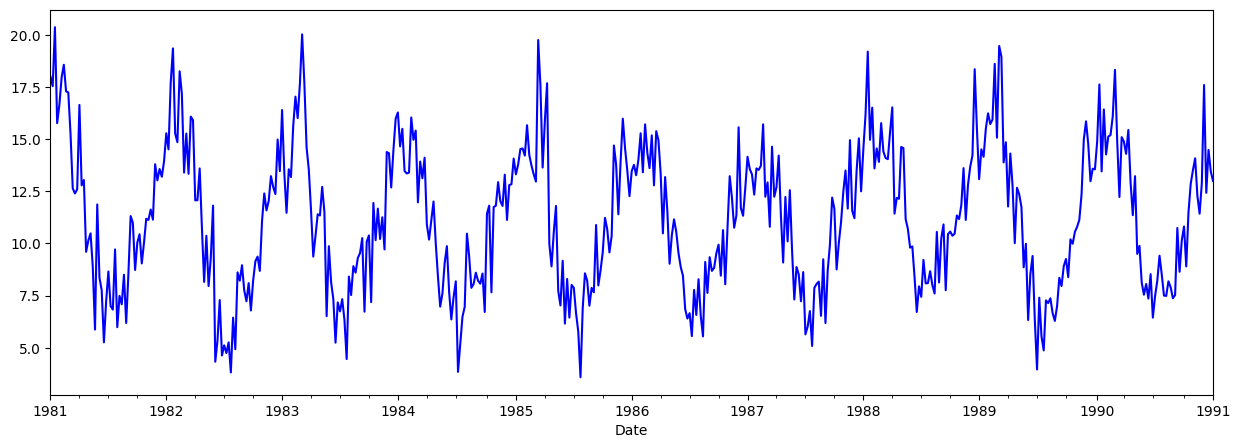

In [8]:
df.Temp.plot(figsize=(15, 5), color='b')

<h2> Dataset splitting

In [9]:
ts_train, ts_test = train_test_split(df, test_size=0.2, shuffle=False)
ts_train.shape, ts_test.shape

((418, 1), (105, 1))

<h2> Dataset & Dataloader

In [10]:
from torch.utils.data import TensorDataset, DataLoader
from jcopdl.utils.dataloader import TimeSeriesDataset

In [11]:
seq_len = 21 # 3 minggu
bs = 16

train_set = TimeSeriesDataset(ts_train, "Temp", seq_len)
trainloader = DataLoader(train_set, batch_size=bs)

test_set = TimeSeriesDataset(ts_test, "Temp", seq_len)
testloader = DataLoader(test_set, batch_size=bs)

(N, S, F): (19, 21, 1)
Note: last 18 data excluded

(N, S, F): (4, 21, 1)
Note: last 20 data excluded



<h2> Arsitektur & Config

In [12]:
from jcopdl.layers import linear_block

In [13]:
class GRU(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.rnn = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout) # NFS -> N/Batch First maka True
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        x, hidden = self.rnn(x, hidden)
        x = self.fc(x)
        return x, hidden
         # hidden bisa tidak perlu dikeluarkan, tapi nanti di loop function tidak usah di define

In [14]:
train_set.n_feature

1

In [15]:
config = set_config({
    "input_size": train_set.n_feature,
    "output_size": 1,
    "hidden_size": 64,
    "num_layers" : 3,
    "dropout" : 0,
    "seq_len": train_set.n_seq
})

<h2> Training Preparation -> MCOC

In [16]:
model = GRU(config.input_size, config.output_size, config.hidden_size, config.num_layers, config.dropout).to(device)
criterion = nn.MSELoss(reduction="mean")
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model", plot_every=100)

In [17]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        #output, hidden -> hidden bisa dibuang jika tidak digunakan
        output, hidden = model(feature, None) # inputnya ada 2, hiddennya None, maka hidden nya otomatis 0
        loss = criterion(output, target)

        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost

Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 132.2714 | Test_cost  = 134.8584 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 123.9629 | Test_cost  = 126.3550 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 115.7069 | Test_cost  = 117.3113 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 106.8876 | Test_cost  = 107.6539 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 97.4709 | Test_cost  = 97.7412 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 87.8480 | Test_cost  = 88.2235 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 78.6798 | Test_cost  = 79.7504 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 70.5973 | Test_cost  = 72.6798 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 63.9181 | Test_cost  = 66.9776 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 58.5757 | Test_cost  = 62.3863 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 54.3005 | Test_cost  = 58.6184 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 50.8069 | Test_cost  = 55.4411 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 47.8690 | Test_cost  = 52.6886 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 45.3281 | Test_cost  = 50.2480 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 43.0772 | Test_cost  = 48.0428 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 41.0446 | Test_cost  = 46.0209 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 39.1818 | Test_cost  = 44.1464 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 37.4559 | Test_cost  = 42.3948 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 35.8445 | Test_cost  = 40.7492 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    20
Train_cost  = 34.3323 | Test_cost  = 39.1976 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    21
Train_cost  = 32.9085 | Test_cost  = 37.7313 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    22
Train_cost  = 31.5652 | Test_cost  = 36.3438 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    23
Train_cost  = 30.2965 | Test_cost  = 35.0297 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    24
Train_cost  = 29.0975 | Test_cost  = 33.7849 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    25
Train_cost  = 27.9644 | Test_cost  = 32.6055 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    26
Train_cost  = 26.8936 | Test_cost  = 31.4883 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    27
Train_cost  = 25.8821 | Test_cost  = 30.4305 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    28
Train_cost  = 24.9271 | Test_cost  = 29.4293 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    29
Train_cost  = 24.0261 | Test_cost  = 28.4821 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    30
Train_cost  = 23.1765 | Test_cost  = 27.5866 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    31
Train_cost  = 22.3760 | Test_cost  = 26.7405 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    32
Train_cost  = 21.6224 | Test_cost  = 25.9416 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    33
Train_cost  = 20.9136 | Test_cost  = 25.1877 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    34
Train_cost  = 20.2473 | Test_cost  = 24.4769 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    35
Train_cost  = 19.6217 | Test_cost  = 23.8069 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    36
Train_cost  = 19.0346 | Test_cost  = 23.1760 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    37
Train_cost  = 18.4843 | Test_cost  = 22.5823 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    38
Train_cost  = 17.9688 | Test_cost  = 22.0239 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    39
Train_cost  = 17.4863 | Test_cost  = 21.4990 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    40
Train_cost  = 17.0352 | Test_cost  = 21.0060 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    41
Train_cost  = 16.6138 | Test_cost  = 20.5432 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    42
Train_cost  = 16.2204 | Test_cost  = 20.1091 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    43
Train_cost  = 15.8535 | Test_cost  = 19.7021 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    44
Train_cost  = 15.5116 | Test_cost  = 19.3207 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    45
Train_cost  = 15.1934 | Test_cost  = 18.9637 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    46
Train_cost  = 14.8974 | Test_cost  = 18.6296 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    47
Train_cost  = 14.6224 | Test_cost  = 18.3171 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    48
Train_cost  = 14.3671 | Test_cost  = 18.0250 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    49
Train_cost  = 14.1303 | Test_cost  = 17.7522 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    50
Train_cost  = 13.9109 | Test_cost  = 17.4976 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    51
Train_cost  = 13.7077 | Test_cost  = 17.2600 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    52
Train_cost  = 13.5199 | Test_cost  = 17.0385 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    53
Train_cost  = 13.3464 | Test_cost  = 16.8320 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    54
Train_cost  = 13.1862 | Test_cost  = 16.6397 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    55
Train_cost  = 13.0386 | Test_cost  = 16.4607 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    56
Train_cost  = 12.9025 | Test_cost  = 16.2941 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    57
Train_cost  = 12.7774 | Test_cost  = 16.1393 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    58
Train_cost  = 12.6624 | Test_cost  = 15.9953 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    59
Train_cost  = 12.5567 | Test_cost  = 15.8616 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    60
Train_cost  = 12.4598 | Test_cost  = 15.7374 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    61
Train_cost  = 12.3710 | Test_cost  = 15.6221 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    62
Train_cost  = 12.2898 | Test_cost  = 15.5152 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    63
Train_cost  = 12.2155 | Test_cost  = 15.4160 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    64
Train_cost  = 12.1476 | Test_cost  = 15.3241 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    65
Train_cost  = 12.0857 | Test_cost  = 15.2389 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    66
Train_cost  = 12.0292 | Test_cost  = 15.1600 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    67
Train_cost  = 11.9778 | Test_cost  = 15.0869 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    68
Train_cost  = 11.9311 | Test_cost  = 15.0192 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    69
Train_cost  = 11.8886 | Test_cost  = 14.9566 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    70
Train_cost  = 11.8500 | Test_cost  = 14.8986 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    71
Train_cost  = 11.8151 | Test_cost  = 14.8450 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    72
Train_cost  = 11.7834 | Test_cost  = 14.7954 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    73
Train_cost  = 11.7548 | Test_cost  = 14.7495 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    74
Train_cost  = 11.7289 | Test_cost  = 14.7071 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    75
Train_cost  = 11.7055 | Test_cost  = 14.6679 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    76
Train_cost  = 11.6844 | Test_cost  = 14.6316 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    77
Train_cost  = 11.6654 | Test_cost  = 14.5980 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    78
Train_cost  = 11.6482 | Test_cost  = 14.5670 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    79
Train_cost  = 11.6328 | Test_cost  = 14.5384 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    80
Train_cost  = 11.6190 | Test_cost  = 14.5119 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    81
Train_cost  = 11.6066 | Test_cost  = 14.4874 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    82
Train_cost  = 11.5954 | Test_cost  = 14.4647 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    83
Train_cost  = 11.5854 | Test_cost  = 14.4438 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    84
Train_cost  = 11.5765 | Test_cost  = 14.4244 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    85
Train_cost  = 11.5685 | Test_cost  = 14.4065 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    87
Train_cost  = 11.5549 | Test_cost  = 14.3746 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    88
Train_cost  = 11.5491 | Test_cost  = 14.3605 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    89
Train_cost  = 11.5440 | Test_cost  = 14.3474 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    90
Train_cost  = 11.5395 | Test_cost  = 14.3352 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    91
Train_cost  = 11.5354 | Test_cost  = 14.3240 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    92
Train_cost  = 11.5318 | Test_cost  = 14.3136 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    93
Train_cost  = 11.5285 | Test_cost  = 14.3040 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    94
Train_cost  = 11.5256 | Test_cost  = 14.2951 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    95
Train_cost  = 11.5230 | Test_cost  = 14.2868 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    96
Train_cost  = 11.5207 | Test_cost  = 14.2792 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    97
Train_cost  = 11.5187 | Test_cost  = 14.2721 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    98
Train_cost  = 11.5168 | Test_cost  = 14.2656 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]

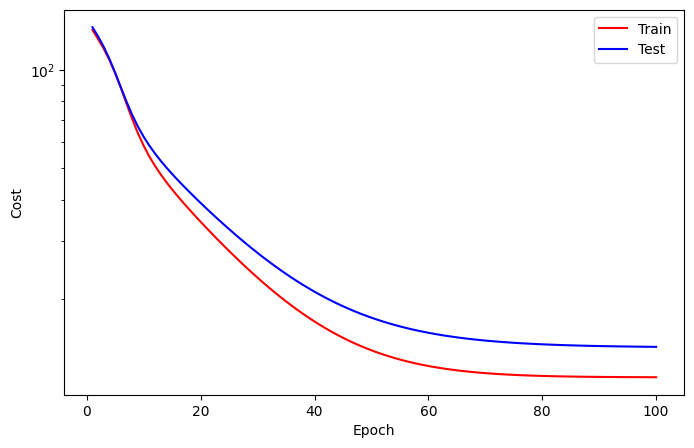

Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   101
Train_cost  = 11.5124 | Test_cost  = 14.2487 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   102
Train_cost  = 11.5112 | Test_cost  = 14.2439 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   103
Train_cost  = 11.5102 | Test_cost  = 14.2394 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   104
Train_cost  = 11.5092 | Test_cost  = 14.2353 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   105
Train_cost  = 11.5084 | Test_cost  = 14.2314 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   106
Train_cost  = 11.5076 | Test_cost  = 14.2279 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   107
Train_cost  = 11.5069 | Test_cost  = 14.2246 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   108
Train_cost  = 11.5063 | Test_cost  = 14.2215 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   109
Train_cost  = 11.5057 | Test_cost  = 14.2187 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   110
Train_cost  = 11.5052 | Test_cost  = 14.2161 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   111
Train_cost  = 11.5047 | Test_cost  = 14.2137 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   112
Train_cost  = 11.5043 | Test_cost  = 14.2114 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   134
Train_cost  = 11.4992 | Test_cost  = 14.1884 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   135
Train_cost  = 11.4990 | Test_cost  = 14.1880 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   136
Train_cost  = 11.4989 | Test_cost  = 14.1876 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   137
Train_cost  = 11.4987 | Test_cost  = 14.1873 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   138
Train_cost  = 11.4986 | Test_cost  = 14.1869 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   139
Train_cost  = 11.4984 | Test_cost  = 14.1866 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   140
Train_cost  = 11.4983 | Test_cost  = 14.1863 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   141
Train_cost  = 11.4982 | Test_cost  = 14.1860 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   142
Train_cost  = 11.4980 | Test_cost  = 14.1858 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   143
Train_cost  = 11.4979 | Test_cost  = 14.1855 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   144
Train_cost  = 11.4978 | Test_cost  = 14.1853 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   145
Train_cost  = 11.4976 | Test_cost  = 14.1850 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   146
Train_cost  = 11.4975 | Test_cost  = 14.1848 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   167
Train_cost  = 11.4948 | Test_cost  = 14.1815 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   168
Train_cost  = 11.4947 | Test_cost  = 14.1814 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   169
Train_cost  = 11.4946 | Test_cost  = 14.1813 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   170
Train_cost  = 11.4945 | Test_cost  = 14.1812 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   171
Train_cost  = 11.4943 | Test_cost  = 14.1810 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   172
Train_cost  = 11.4942 | Test_cost  = 14.1809 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   173
Train_cost  = 11.4941 | Test_cost  = 14.1808 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   174
Train_cost  = 11.4940 | Test_cost  = 14.1807 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   175
Train_cost  = 11.4938 | Test_cost  = 14.1805 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   176
Train_cost  = 11.4937 | Test_cost  = 14.1804 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   177
Train_cost  = 11.4936 | Test_cost  = 14.1803 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   178
Train_cost  = 11.4935 | Test_cost  = 14.1802 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   179
Train_cost  = 11.4933 | Test_cost  = 14.1801 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   190
Train_cost  = 11.4919 | Test_cost  = 14.1789 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   191
Train_cost  = 11.4918 | Test_cost  = 14.1788 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   192
Train_cost  = 11.4917 | Test_cost  = 14.1787 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   193
Train_cost  = 11.4916 | Test_cost  = 14.1786 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   194
Train_cost  = 11.4914 | Test_cost  = 14.1785 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   195
Train_cost  = 11.4913 | Test_cost  = 14.1784 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   196
Train_cost  = 11.4912 | Test_cost  = 14.1783 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   197
Train_cost  = 11.4910 | Test_cost  = 14.1782 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   198
Train_cost  = 11.4909 | Test_cost  = 14.1781 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   199
Train_cost  = 11.4908 | Test_cost  = 14.1780 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   200
Train_cost  = 11.4907 | Test_cost  = 14.1779 | 


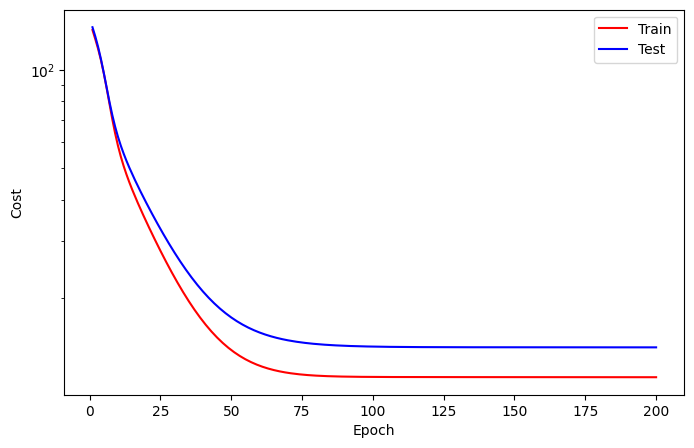

Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   201
Train_cost  = 11.4905 | Test_cost  = 14.1778 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   202
Train_cost  = 11.4904 | Test_cost  = 14.1777 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   203
Train_cost  = 11.4903 | Test_cost  = 14.1776 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   204
Train_cost  = 11.4901 | Test_cost  = 14.1775 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   205
Train_cost  = 11.4900 | Test_cost  = 14.1774 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   206
Train_cost  = 11.4899 | Test_cost  = 14.1773 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   207
Train_cost  = 11.4897 | Test_cost  = 14.1772 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   208
Train_cost  = 11.4896 | Test_cost  = 14.1771 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   209
Train_cost  = 11.4895 | Test_cost  = 14.1770 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   210
Train_cost  = 11.4893 | Test_cost  = 14.1769 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   211
Train_cost  = 11.4892 | Test_cost  = 14.1768 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   212
Train_cost  = 11.4891 | Test_cost  = 14.1767 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   213
Train_cost  = 11.4889 | Test_cost  = 14.1767 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   214
Train_cost  = 11.4888 | Test_cost  = 14.1766 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   215
Train_cost  = 11.4887 | Test_cost  = 14.1765 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   218
Train_cost  = 11.4883 | Test_cost  = 14.1762 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   219
Train_cost  = 11.4881 | Test_cost  = 14.1761 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   220
Train_cost  = 11.4880 | Test_cost  = 14.1761 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   221
Train_cost  = 11.4879 | Test_cost  = 14.1760 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   222
Train_cost  = 11.4877 | Test_cost  = 14.1759 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   223
Train_cost  = 11.4876 | Test_cost  = 14.1758 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   224
Train_cost  = 11.4875 | Test_cost  = 14.1757 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   225
Train_cost  = 11.4873 | Test_cost  = 14.1757 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   226
Train_cost  = 11.4872 | Test_cost  = 14.1756 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   227
Train_cost  = 11.4870 | Test_cost  = 14.1755 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   228
Train_cost  = 11.4869 | Test_cost  = 14.1754 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   229
Train_cost  = 11.4868 | Test_cost  = 14.1754 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   252
Train_cost  = 11.4835 | Test_cost  = 14.1738 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   253
Train_cost  = 11.4833 | Test_cost  = 14.1737 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   254
Train_cost  = 11.4832 | Test_cost  = 14.1736 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   255
Train_cost  = 11.4830 | Test_cost  = 14.1736 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   256
Train_cost  = 11.4829 | Test_cost  = 14.1735 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   257
Train_cost  = 11.4827 | Test_cost  = 14.1735 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   258
Train_cost  = 11.4826 | Test_cost  = 14.1734 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   259
Train_cost  = 11.4824 | Test_cost  = 14.1733 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   260
Train_cost  = 11.4823 | Test_cost  = 14.1733 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   261
Train_cost  = 11.4821 | Test_cost  = 14.1732 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   262
Train_cost  = 11.4820 | Test_cost  = 14.1732 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   263
Train_cost  = 11.4818 | Test_cost  = 14.1731 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   264
Train_cost  = 11.4817 | Test_cost  = 14.1730 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   274
Train_cost  = 11.4801 | Test_cost  = 14.1725 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   275
Train_cost  = 11.4800 | Test_cost  = 14.1724 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   276
Train_cost  = 11.4798 | Test_cost  = 14.1724 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   277
Train_cost  = 11.4796 | Test_cost  = 14.1723 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   278
Train_cost  = 11.4795 | Test_cost  = 14.1723 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   279
Train_cost  = 11.4793 | Test_cost  = 14.1722 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   280
Train_cost  = 11.4792 | Test_cost  = 14.1722 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   281
Train_cost  = 11.4790 | Test_cost  = 14.1721 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   282
Train_cost  = 11.4788 | Test_cost  = 14.1721 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   283
Train_cost  = 11.4787 | Test_cost  = 14.1720 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   284
Train_cost  = 11.4785 | Test_cost  = 14.1720 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   285
Train_cost  = 11.4783 | Test_cost  = 14.1719 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   286
Train_cost  = 11.4782 | Test_cost  = 14.1719 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   301
Train_cost  = 11.4756 | Test_cost  = 14.1711 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   302
Train_cost  = 11.4754 | Test_cost  = 14.1711 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   303
Train_cost  = 11.4753 | Test_cost  = 14.1710 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   304
Train_cost  = 11.4751 | Test_cost  = 14.1710 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   305
Train_cost  = 11.4749 | Test_cost  = 14.1709 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   306
Train_cost  = 11.4747 | Test_cost  = 14.1709 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   307
Train_cost  = 11.4745 | Test_cost  = 14.1708 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   308
Train_cost  = 11.4744 | Test_cost  = 14.1708 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   309
Train_cost  = 11.4742 | Test_cost  = 14.1707 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   310
Train_cost  = 11.4740 | Test_cost  = 14.1707 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   311
Train_cost  = 11.4738 | Test_cost  = 14.1706 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   312
Train_cost  = 11.4736 | Test_cost  = 14.1706 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   313
Train_cost  = 11.4734 | Test_cost  = 14.1705 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   344
Train_cost  = 11.4668 | Test_cost  = 14.1687 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   345
Train_cost  = 11.4666 | Test_cost  = 14.1686 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   346
Train_cost  = 11.4663 | Test_cost  = 14.1685 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   347
Train_cost  = 11.4661 | Test_cost  = 14.1684 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   348
Train_cost  = 11.4658 | Test_cost  = 14.1683 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   349
Train_cost  = 11.4655 | Test_cost  = 14.1682 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   350
Train_cost  = 11.4653 | Test_cost  = 14.1681 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   351
Train_cost  = 11.4650 | Test_cost  = 14.1680 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   352
Train_cost  = 11.4647 | Test_cost  = 14.1679 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   353
Train_cost  = 11.4645 | Test_cost  = 14.1678 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   354
Train_cost  = 11.4642 | Test_cost  = 14.1677 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   355
Train_cost  = 11.4639 | Test_cost  = 14.1676 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   356
Train_cost  = 11.4636 | Test_cost  = 14.1675 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   386
Train_cost  = 11.4473 | Test_cost  = 14.1556 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   387
Train_cost  = 11.4458 | Test_cost  = 14.1541 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   388
Train_cost  = 11.4442 | Test_cost  = 14.1523 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   389
Train_cost  = 11.4423 | Test_cost  = 14.1501 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   390
Train_cost  = 11.4400 | Test_cost  = 14.1476 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   391
Train_cost  = 11.4374 | Test_cost  = 14.1445 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   392
Train_cost  = 11.4344 | Test_cost  = 14.1408 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   393
Train_cost  = 11.4308 | Test_cost  = 14.1363 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   394
Train_cost  = 11.4265 | Test_cost  = 14.1309 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   395
Train_cost  = 11.4214 | Test_cost  = 14.1242 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   396
Train_cost  = 11.4151 | Test_cost  = 14.1157 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   397
Train_cost  = 11.4071 | Test_cost  = 14.1047 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   398
Train_cost  = 11.3970 | Test_cost  = 14.0901 | 


Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   425
Train_cost  = 5.6235 | Test_cost  = 6.2201 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   426
Train_cost  = 5.4616 | Test_cost  = 6.0272 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   427
Train_cost  = 5.3098 | Test_cost  = 5.8296 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   428
Train_cost  = 5.1641 | Test_cost  = 5.6189 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   429
Train_cost  = 5.0177 | Test_cost  = 5.4491 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   430
Train_cost  = 4.8807 | Test_cost  = 5.3158 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   431
Train_cost  = 4.7566 | Test_cost  = 5.1816 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   432
Train_cost  = 4.6412 | Test_cost  = 5.0453 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   433
Train_cost  = 4.5337 | Test_cost  = 4.9298 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   434
Train_cost  = 4.4389 | Test_cost  = 4.8203 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   435
Train_cost  = 4.3542 | Test_cost  = 4.6994 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   436
Train_cost  = 4.2709 | Test_cost  = 4.5929 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   485
Train_cost  = 3.1178 | Test_cost  = 3.1454 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   486
Train_cost  = 3.1095 | Test_cost  = 3.1436 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   487
Train_cost  = 3.1014 | Test_cost  = 3.1422 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   488
Train_cost  = 3.0934 | Test_cost  = 3.1409 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   489
Train_cost  = 3.0854 | Test_cost  = 3.1402 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   490
Train_cost  = 3.0775 | Test_cost  = 3.1404 | 
==> EarlyStop patience =  1 | Best test_cost: 3.1402


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   491
Train_cost  = 3.0703 | Test_cost  = 3.1424 | 
==> EarlyStop patience =  2 | Best test_cost: 3.1402


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   492
Train_cost  = 3.0638 | Test_cost  = 3.1460 | 
==> EarlyStop patience =  3 | Best test_cost: 3.1402


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   493
Train_cost  = 3.0583 | Test_cost  = 3.1514 | 
==> EarlyStop patience =  4 | Best test_cost: 3.1402


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   494
Train_cost  = 3.0536 | Test_cost  = 3.1575 | 
==> EarlyStop patience =  5 | Best test_cost: 3.1402
==> Execute Early Stopping at epoch: 494 | Best test_cost: 3.1402
==> Best model is saved at model


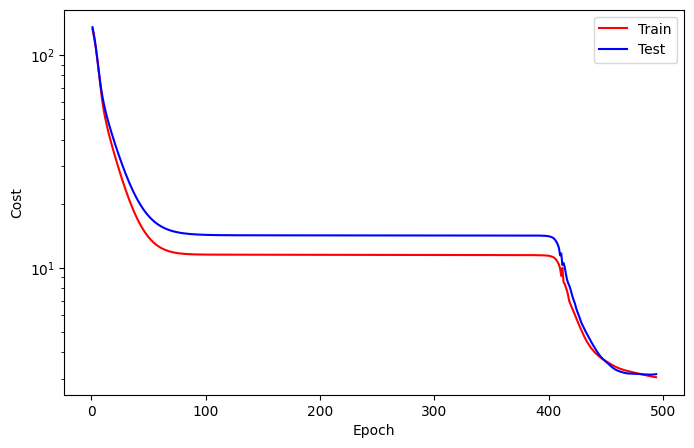

In [18]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)

    # logging
    callback.log(train_cost, test_cost)

    # checkpoint
    callback.save_checkpoint()

    # runtime plotting
    callback.cost_runtime_plotting()

    # early stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

<h2> Forecast

In [19]:
def data4pred(model, dataset, dataloader, device):
    preds, targets = [], []
    hidden = None
    with torch.no_grad():
        model.eval()
        for inputs, target in dataloader:
            inputs = inputs.to(device)

            output, hidden = model(inputs, hidden)
            preds += output.flatten().tolist()
            targets += target.flatten().tolist()

    plt.plot(dataset.target_ticks, targets, 'b-', label="data")
    plt.plot(dataset.target_ticks, preds, 'r-', label="pred")
    plt.legend()

def pred4pred(model, dataset, dataloader, device, n_prior=75, n_forecast=30):
    preds, targets = [], []
    hidden = None
    end = n_prior + n_forecast
    with torch.no_grad():
        model.eval()
        for idx, (inputs, target) in enumerate(dataloader):
            if idx == end:
                break
            elif idx > n_prior:
                inputs[0, 0, 0] = preds[-1]

            inputs = inputs.to(device)
            output, hidden = model(inputs, hidden)

            if idx > n_prior:
                preds.append(output.flatten().tolist()[-1])
            else:
                preds += output.flatten().tolist()
            targets += target.flatten().tolist()

    plt.plot(dataset.target_ticks[:n_prior], targets[:n_prior], 'b-', label="history_data")
    plt.plot(dataset.target_ticks[n_prior:end], targets[n_prior:], 'b-', label="unseen_data", alpha=0.3)
    plt.plot(dataset.target_ticks[:end], preds, 'r-', label="prediction")
    plt.axvline(dataset.target_ticks[n_prior], color='k', linestyle="--", linewidth=1)
    plt.legend()

In [20]:
train_forecast_set = TimeSeriesDataset(ts_train, "Temp", 1) # forecasting jadi per 1 data, input 1 pred 1
trainforecastloader = DataLoader(train_forecast_set)

test_forecast_set = TimeSeriesDataset(ts_test, "Temp", 1)
testforecastloader = DataLoader(test_forecast_set)

(N, S, F): (417, 1, 1)
Note: last 0 data excluded

(N, S, F): (104, 1, 1)
Note: last 0 data excluded



Text(0.5, 1.0, 'Test')

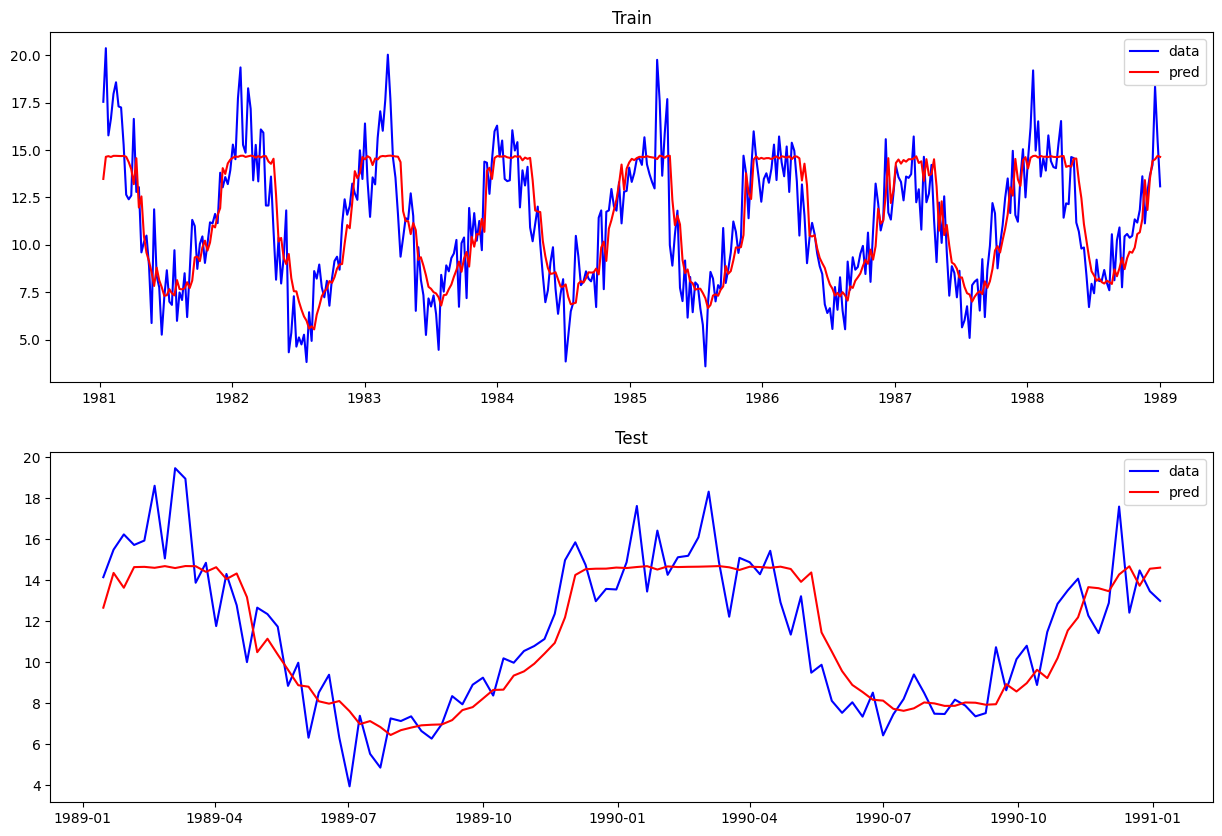

In [21]:
plt.figure(figsize=(15, 10))

plt.subplot(211)
data4pred(model, train_forecast_set, trainforecastloader, device)
plt.title("Train")

plt.subplot(212)
data4pred(model, test_forecast_set, testforecastloader, device)
plt.title("Test")

Text(0.5, 1.0, 'Test')

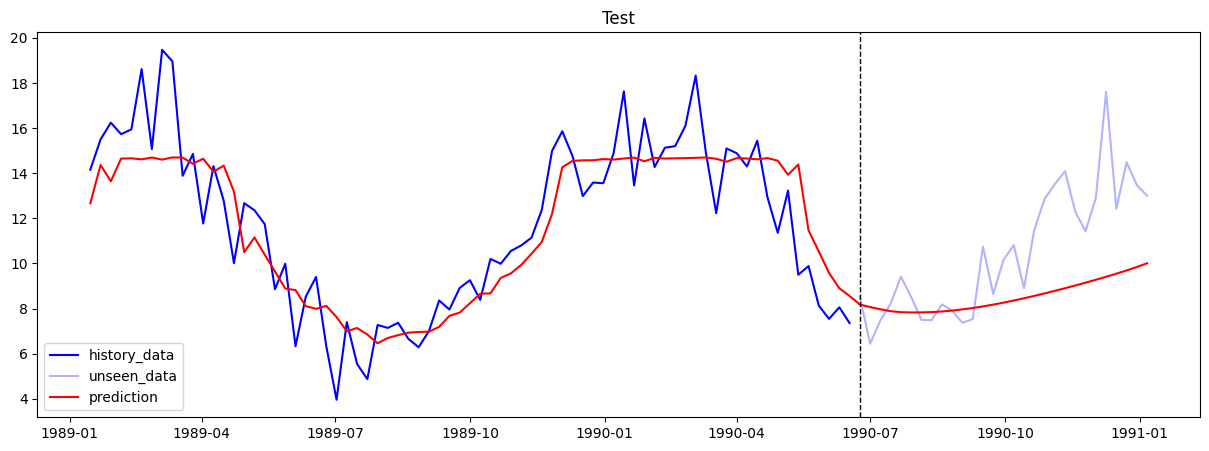

In [22]:
plt.figure(figsize=(15,5))
pred4pred(model, test_forecast_set, testforecastloader, device)
plt.title("Test")